# Google Search Terms

This notebook is for Exploratory Data Analysis for search data from Google Trends.    
The following data is collected from [Google Trends](#https://trends.google.com/trends/explore?geo=SG&hl=en-US).    
Google Trends is a site that provides freqency for search datas, which can be based on location.  
In this notebook, only searches from Singapore are used.  

The data will first be preprocessed so they can be analysed.   
Simple data EDA will be performed on data to obtain a rough understanding of it.  
As data is time series in nature, `acf` and `pacf` will be performed on data.  

### Content 
1. [Preprocessing](#Preprocessing)
2. [Simple EDA](#Simple-EDA)
3. [Original Data](#Original-Data)
4. [1st Diff](#1st-Diff)
5. [2nd Diff](#2nd-Diff)

In [1]:
import warnings
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import stats models
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

2023-04-11 21:38:17.882550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 21:38:18.722511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Preprocessing

The data from Google Trend will scale the y axis according to the time range examined.  
Therefore, in order to keep the data at a weekly level, 2 time periods are used.  
To ensure that the scale is the same, the week of maximum interest is present in both data sets.  
Some time periods from this 2 parts are overlapping and recorded the exact same value.  
This shows that the scale of the data is the same.  

The data ranges from: 2013-05-23 to 2020-11-06.  
They are aggregated as weekly data by Google Trend.  
The actual data are from: 2013-05-26 to 2020-11-01.  

In [2]:
df_part_1 = pd.read_csv('../assets/dengue_part_1.csv')
df_part_2 = pd.read_csv('../assets/dengue_part_2.csv')

Head of part 2

In [3]:
df_part_1.loc[df_part_1['Week']=='8/11/2015']

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
128,8/11/2015,6,5,7,1


Only keep part 1 data that's not in part 2.

In [4]:
df_part_1 = df_part_1.iloc[:128,:]
df_part_1.tail()

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
123,4/10/2015,7,7,6,1
124,11/10/2015,6,4,6,3
125,18/10/2015,7,6,7,1
126,25/10/2015,6,6,5,1
127,1/11/2015,8,6,6,1


Combine the data using concat.

In [5]:
df = pd.concat([df_part_1, df_part_2])
df.iloc[127:133,:]

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
127,1/11/2015,8,6,6,1
0,8/11/2015,6,5,7,1
1,15/11/2015,7,6,7,3
2,22/11/2015,7,6,6,2
3,29/11/2015,6,6,7,2
4,6/12/2015,7,7,5,2


In [6]:
df.reset_index(inplace=True, drop=True)
df.iloc[126:133,:]

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
126,25/10/2015,6,6,5,1
127,1/11/2015,8,6,6,1
128,8/11/2015,6,5,7,1
129,15/11/2015,7,6,7,3
130,22/11/2015,7,6,6,2
131,29/11/2015,6,6,7,2
132,6/12/2015,7,7,5,2


In [7]:
# Check if there are null values
df.isnull().sum()

Week                             0
Dengue fever: (Singapore)        0
Dengue: (Singapore)              0
Mosquito: (Singapore)            0
Insect repellent: (Singapore)    0
dtype: int64

In [8]:
display(len(df))

389

In [9]:
# Change the 1st column to date time format
df['Week'] = pd.to_datetime(df['Week'], dayfirst=True);
# Convert datetime to intended string format
df['Week'] = df['Week'].dt.strftime('%Y-%m-%d')
#display df
df.head()

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
0,2013-05-26,33,30,10,2
1,2013-06-02,29,28,9,3
2,2013-06-09,56,52,18,4
3,2013-06-16,42,39,14,2
4,2013-06-23,25,23,8,2


In [10]:
df.loc[df['Mosquito: (Singapore)']==100]

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
170,2016-08-28,17,16,100,57


In [11]:
df.loc[df['Insect repellent: (Singapore)']=='<1']

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
13,2013-08-25,11,11,7,<1
179,2016-10-30,5,4,7,<1
273,2018-08-19,4,3,6,<1


In [12]:
df['Insect repellent: (Singapore)'].replace('<1', 1, inplace=True)

Replace the special characters present.  

In [13]:
df.loc[df['Insect repellent: (Singapore)']=='<1']

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)


In [14]:
df.loc[df['Dengue: (Singapore)']=='<1']

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)


In [15]:
df.loc[df['Dengue fever: (Singapore)']=='<1']

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)


In [16]:
df.loc[df['Mosquito: (Singapore)']=='<1']

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)


In [17]:
df_int = df.iloc[:,1:5].astype(int)

In [18]:
df_int.head()

,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
0,33,30,10,2
1,29,28,9,3
2,56,52,18,4
3,42,39,14,2
4,25,23,8,2


In [19]:
df.drop(columns=['Dengue fever: (Singapore)', 'Dengue: (Singapore)', 'Mosquito: (Singapore)', 'Insect repellent: (Singapore)'],inplace=True)
df = pd.concat([df, df_int], axis=1)
df.head()

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
0,2013-05-26,33,30,10,2
1,2013-06-02,29,28,9,3
2,2013-06-09,56,52,18,4
3,2013-06-16,42,39,14,2
4,2013-06-23,25,23,8,2


The data from Google Trends are interest over time.  
The y axis are interests, and the x axis are the time.

The following is from Google Trend webbsite explaining how to interpret the data.  
```bash
"
Numbers represent search interest relative to the highest point on the chart for the given region and time. 
A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. 
A score of 0 means there was not enough data for this term.
"
```

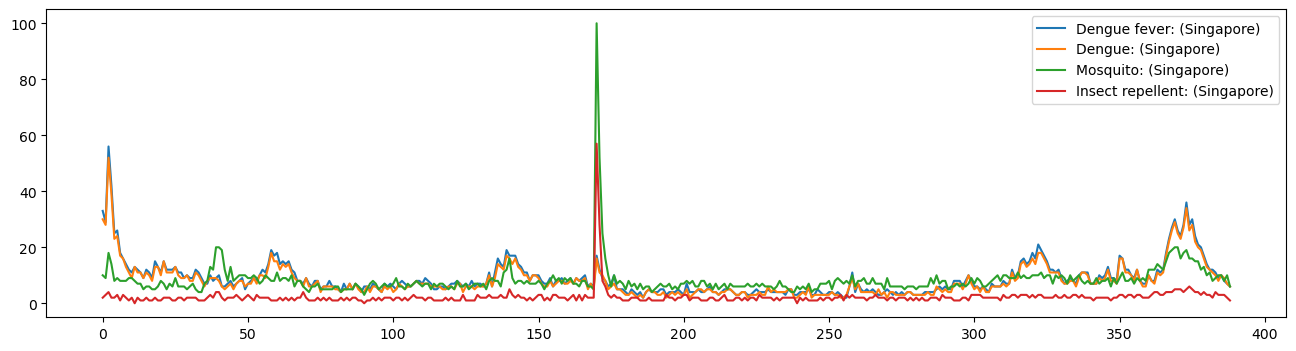

In [20]:
# Plot the original trend
fig = plt.figure(figsize=(16,4))
plt.plot(df.index, df.iloc[:,1:5]);
plt.legend(['Dengue fever: (Singapore)', 'Dengue: (Singapore)', 'Mosquito: (Singapore)', 'Insect repellent: (Singapore)']);

## Simple EDA

Basic and simple EDA will be performed on the data present.  
Such as aggregating the data, and also looking at summary statistics.  

In [21]:
# 1 month is approximately 4 weeks. Hence rolling window of 4.
df_roll_4 = df.iloc[:,1:5].rolling(4).mean()

In [22]:
df_roll_4.head()

,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore)
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,40.0,37.25,12.75,2.75
4,38.0,35.50,12.25,2.75


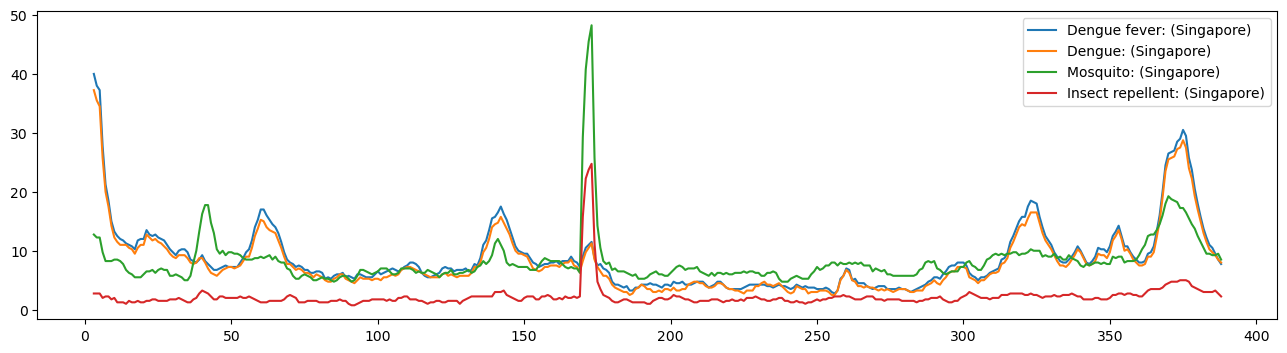

In [23]:
# Plot the trend for rolling window of 4 days
fig = plt.figure(figsize=(16,4))
plt.plot(df_roll_4.index, df_roll_4);
plt.legend(['Dengue fever: (Singapore)', 'Dengue: (Singapore)', 'Mosquito: (Singapore)', 'Insect repellent: (Singapore)']);

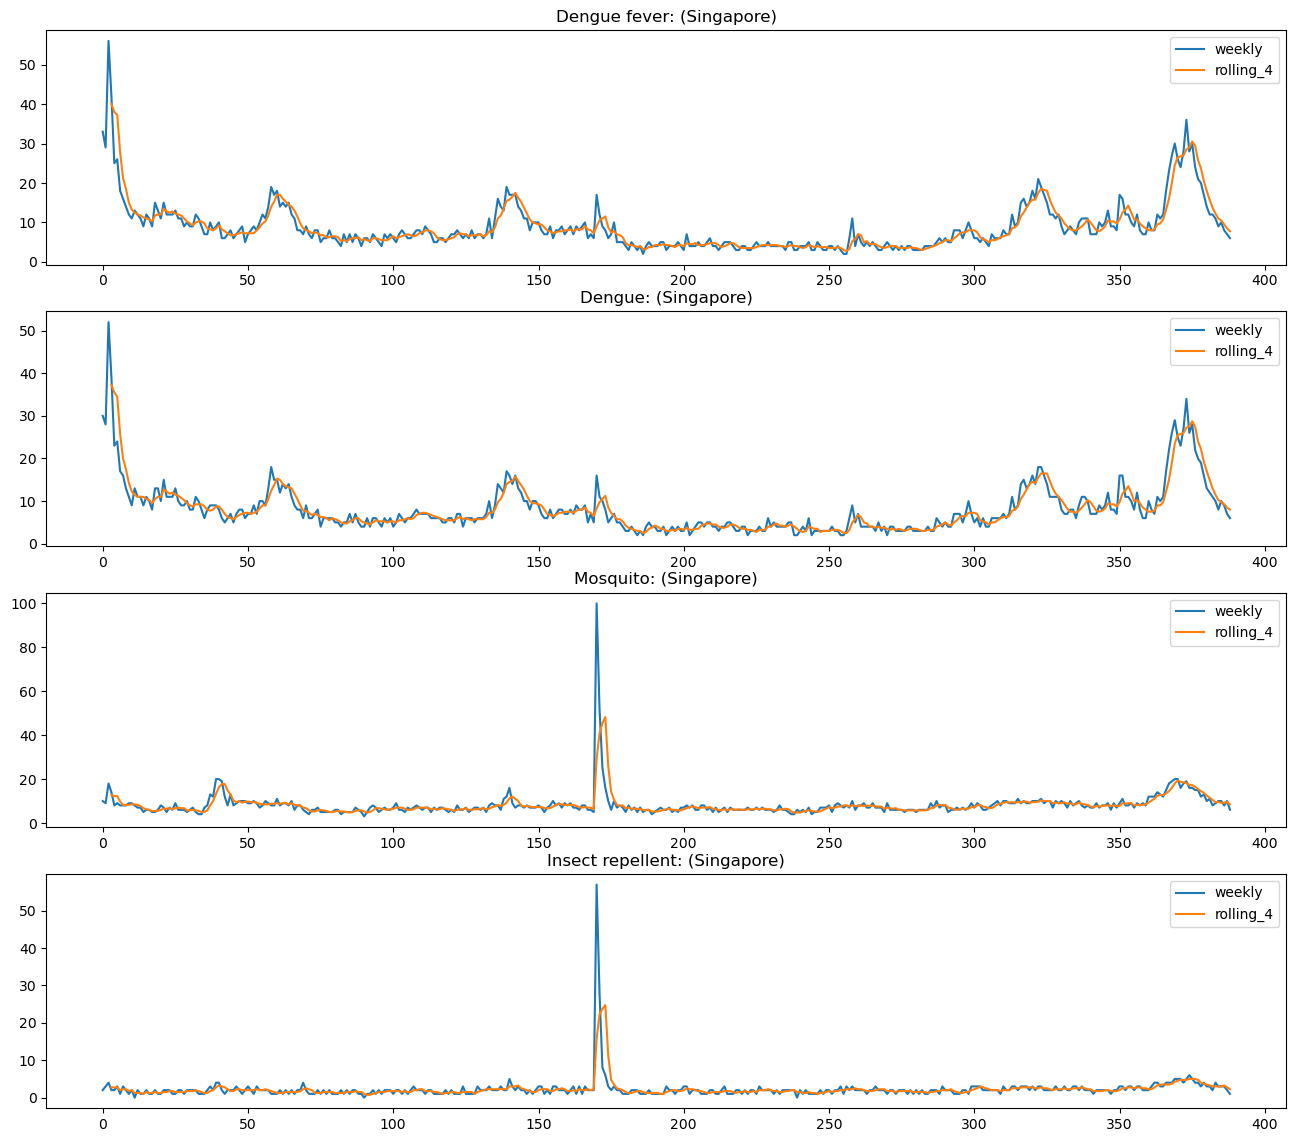

In [24]:
# compare rolling_4 and actual weekly
title_list = ['Dengue fever: (Singapore)', 'Dengue: (Singapore)', 'Mosquito: (Singapore)', 'Insect repellent: (Singapore)']
fig, axes = plt.subplots(nrows=4, figsize=(16,14))
for i, col_name in enumerate(title_list):
    axes[i].plot(df[col_name]);
    axes[i].plot(df[col_name].rolling(4).mean());
    axes[i].legend(['weekly','rolling_4'])
    axes[i].title.set_text(col_name)

Looking at the monthly data, it seems that the interest in `mosquito` and `insect repellent` died down very quickly.  
This may mean that the situation quickly got under control.  
Otherwise, there should be a prolonged interest in both of the search terms.  
However, the decrease in interest is very sharp.  
This tell me that there is a sudden drop in interest, probably becasue the situation got under control quickly.  

The interest in Dengue and Dengue fever are almost the same shape.  
This is to be expected as they are the 2 sides of the same coin.  
Also, the trends are very similar.  
There don't seem to be a lag or lead over each other.  
They do appear to have a some what seasonal pattern.  

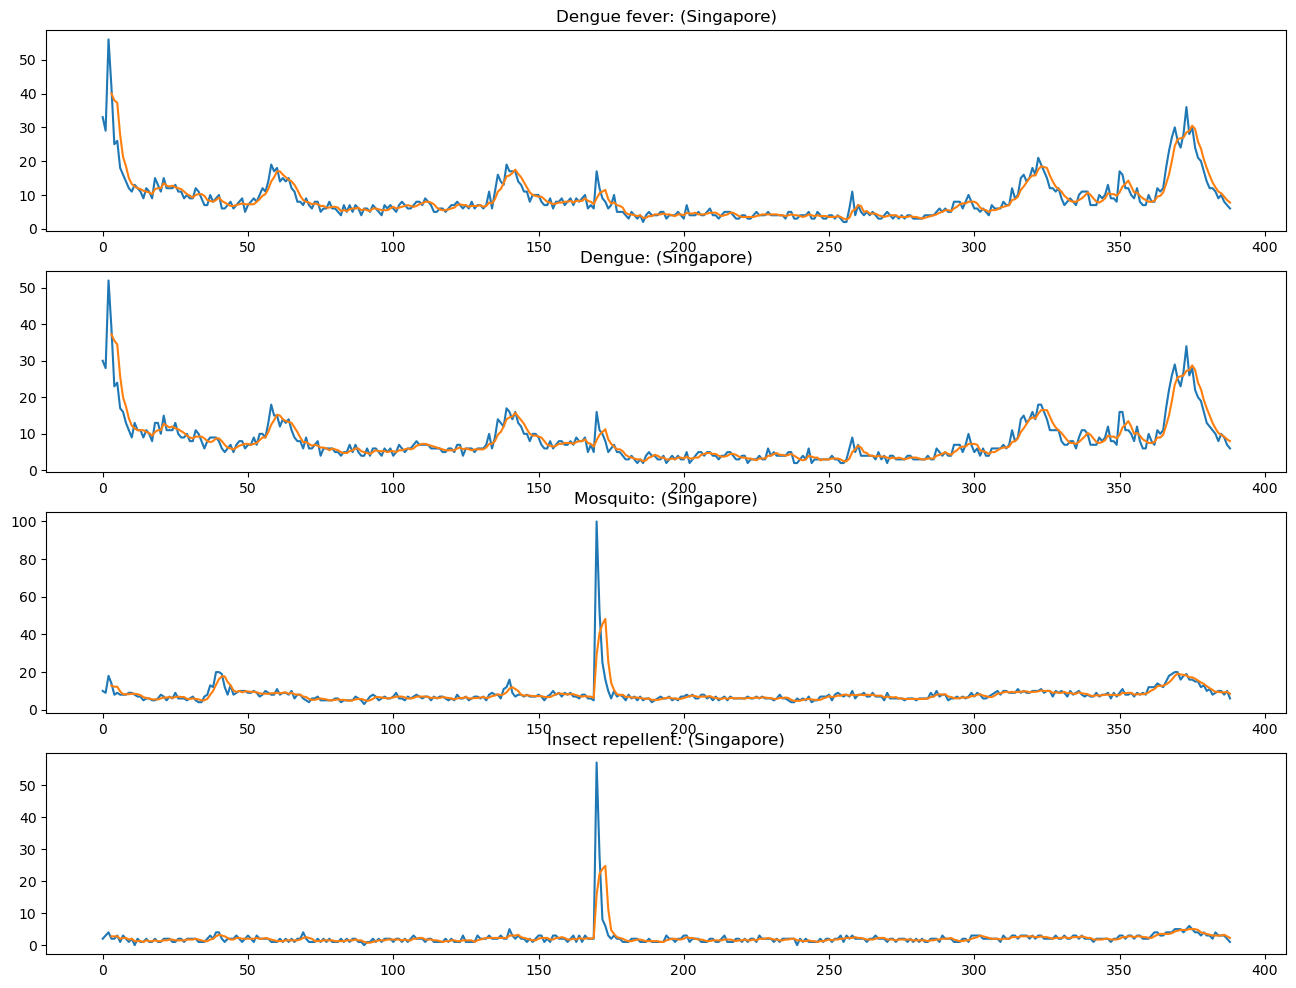

In [25]:
fig, axes = plt.subplots(nrows=4, figsize=(16,12))
for i, col_name in enumerate(title_list):
    axes[i].plot(df[col_name]);
    axes[i].plot(df[col_name].rolling(4).mean());
    axes[i].title.set_text(col_name)

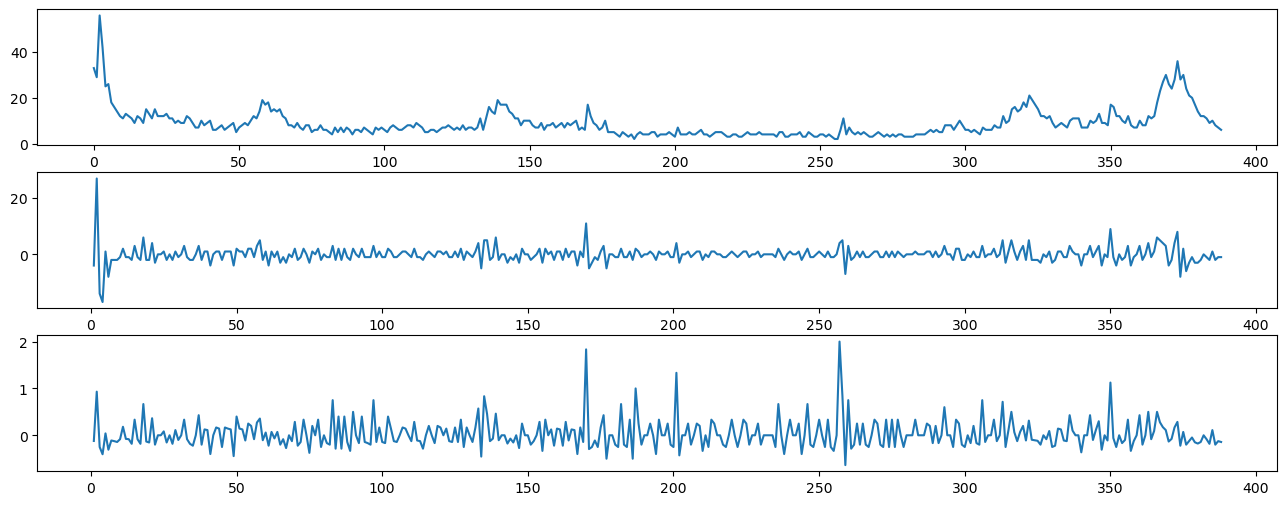

In [26]:
# The diff and % changes for Dengue Fever (Diesease)
fig, axes = plt.subplots(nrows=3, figsize=(16,6))
axes[0].plot(df.iloc[:,1]);
axes[1].plot(df.iloc[:,1].diff());
axes[2].plot(df.iloc[:,1].pct_change());

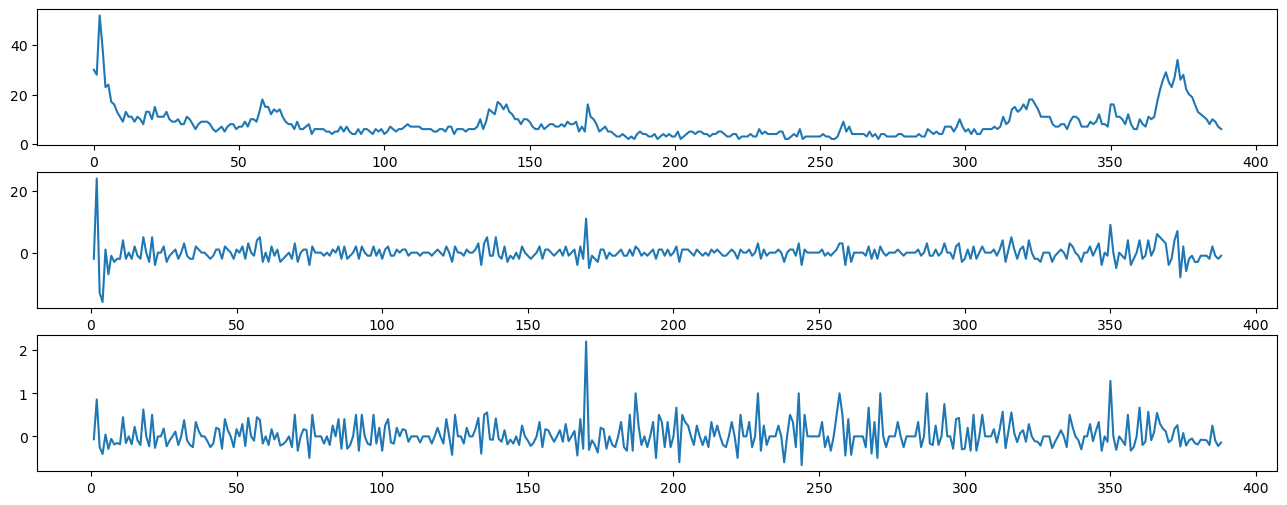

In [27]:
# The diff and % changes for Dengue (Search Term)
fig, axes = plt.subplots(nrows=3, figsize=(16,6))
axes[0].plot(df.iloc[:,2]);
axes[1].plot(df.iloc[:,2].diff());
axes[2].plot(df.iloc[:,2].pct_change());

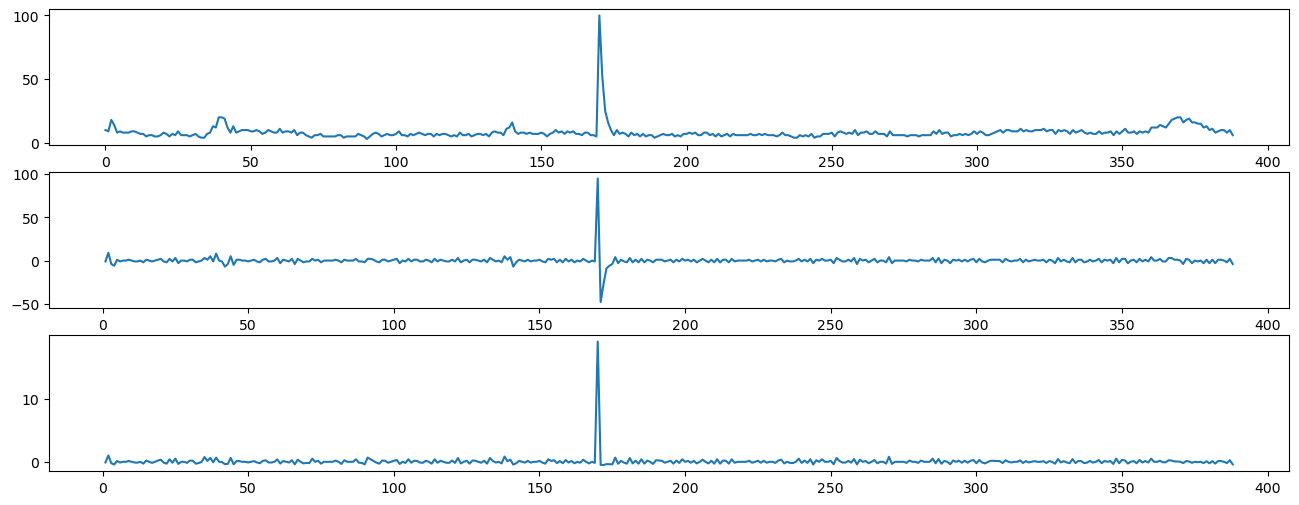

In [28]:
# The diff and % changes for Mosquito (Insect)
fig, axes = plt.subplots(nrows=3, figsize=(16,6))
axes[0].plot(df.iloc[:,3]);
axes[1].plot(df.iloc[:,3].diff());
axes[2].plot(df.iloc[:,3].pct_change());

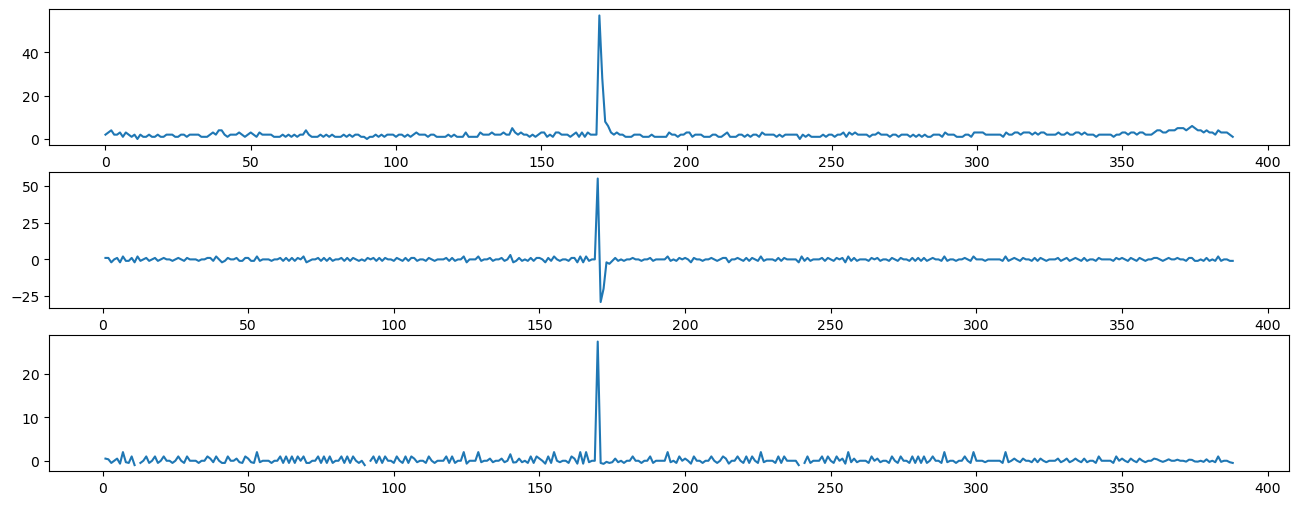

In [29]:
# The diff and % changes for Insect repellent (Search Term)
fig, axes = plt.subplots(nrows=3, figsize=(16,6))
axes[0].plot(df.iloc[:,4]);
axes[1].plot(df.iloc[:,4].diff());
axes[2].plot(df.iloc[:,4].pct_change());

There is a sharp spike in interest for `mosquito` and `insect repellent` for 2016-08-08.  
From domain knowledge, this is due to a sudden wave of `Zika` hitting Singapore.  
Similar to Dengue, Zika is also a disease spread by mosquito.  
Also according to our own research/ domain knowledge, `Zika` and `Dengue` have a some what inverse relationship.  
The anomaly in data, the spike, is a result of higher awareness of `Zika` spreading in Singapore. 

In [30]:
#Look at the diff and .diff().diff()
for col_title in title_list:
    df[col_title+'diff'] = df[col_title].diff()
    df[col_title+'2nd_diff'] = df[col_title].diff().diff()

In [31]:
df.head()

,Week,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore),Dengue fever: (Singapore)diff,Dengue fever: (Singapore)2nd_diff,Dengue: (Singapore)diff,Dengue: (Singapore)2nd_diff,Mosquito: (Singapore)diff,Mosquito: (Singapore)2nd_diff,Insect repellent: (Singapore)diff,Insect repellent: (Singapore)2nd_diff
0,2013-05-26,33,30,10,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-06-02,29,28,9,3,-4.0,NaN,-2.0,NaN,-1.0,NaN,1.0,NaN
2,2013-06-09,56,52,18,4,27.0,31.0,24.0,26.0,9.0,10.0,1.0,0.0
3,2013-06-16,42,39,14,2,-14.0,-41.0,-13.0,-37.0,-4.0,-13.0,-2.0,-3.0
4,2013-06-23,25,23,8,2,-17.0,-3.0,-16.0,-3.0,-6.0,-2.0,0.0,2.0


In [32]:
df.describe()

,Dengue fever: (Singapore),Dengue: (Singapore),Mosquito: (Singapore),Insect repellent: (Singapore),Dengue fever: (Singapore)diff,Dengue fever: (Singapore)2nd_diff,Dengue: (Singapore)diff,Dengue: (Singapore)2nd_diff,Mosquito: (Singapore)diff,Mosquito: (Singapore)2nd_diff,Insect repellent: (Singapore)diff,Insect repellent: (Singapore)2nd_diff
count,389.000000,389.000000,389.000000,389.000000,388.000000,387.000000,388.000000,387.000000,388.000000,387.000000,388.000000,387.000000
mean,8.748072,8.069409,8.231362,2.226221,-0.069588,0.007752,-0.061856,0.002584,-0.010309,-0.007752,-0.002577,-0.005168
std,6.163852,5.807728,5.978738,3.230849,2.828026,4.394703,2.651369,4.104527,5.908860,9.393385,3.454016,5.458271
min,2.000000,2.000000,3.000000,0.000000,-17.000000,-41.000000,-16.000000,-37.000000,-48.000000,-143.000000,-29.000000,-84.000000
25%,5.000000,4.000000,6.000000,1.000000,-1.000000,-2.000000,-1.000000,-2.000000,-1.000000,-2.000000,-1.000000,-1.000000
50%,7.000000,7.000000,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11.000000,10.000000,9.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
max,56.000000,52.000000,100.000000,57.000000,27.000000,31.000000,24.000000,26.000000,95.000000,96.000000,55.000000,55.000000


The mean value for interest in `Dengue fever`, `Dengue` and `mosquito` is in the range of 8 to 9.  
This is at a relatively low level compared to the peak interest on `mosquito` at 100 during the Zika out break in 2016.   
This tell us that most of the time, citizens doesn't really care about `mosquito`, unless an outbreak takes place.    
However, the mean interest level for `Dengue` and `Mosquito` are similar.  
This shows that that `Mosquito`, `Dengue` & `Dengue fever` are highly related.  
Perhaps this also indicate that the public is well aware of the relationship between the two.  
Unfornuately, ther is no distinct leading or lagging relationship between interest on `Mosquito` and `Dengue`.  
From the statistics, it also can be seen that most the time, the interest for `Mosquito`, `Dengue` & `Dengue fever` remains low.  

In [33]:
df.median(numeric_only=True)

Dengue fever: (Singapore)                7.0
Dengue: (Singapore)                      7.0
Mosquito: (Singapore)                    7.0
Insect repellent: (Singapore)            2.0
Dengue fever: (Singapore)diff            0.0
Dengue fever: (Singapore)2nd_diff        0.0
Dengue: (Singapore)diff                  0.0
Dengue: (Singapore)2nd_diff              0.0
Mosquito: (Singapore)diff                0.0
Mosquito: (Singapore)2nd_diff            0.0
Insect repellent: (Singapore)diff        0.0
Insect repellent: (Singapore)2nd_diff    0.0
dtype: float64

Mode is a better represnetation of interest level on `Dengue` and `Mosquito` etc.  
This can be useful as an interest of more than 7 or 8 can probably be a tell tale sign for a potential increase in number of cases.  

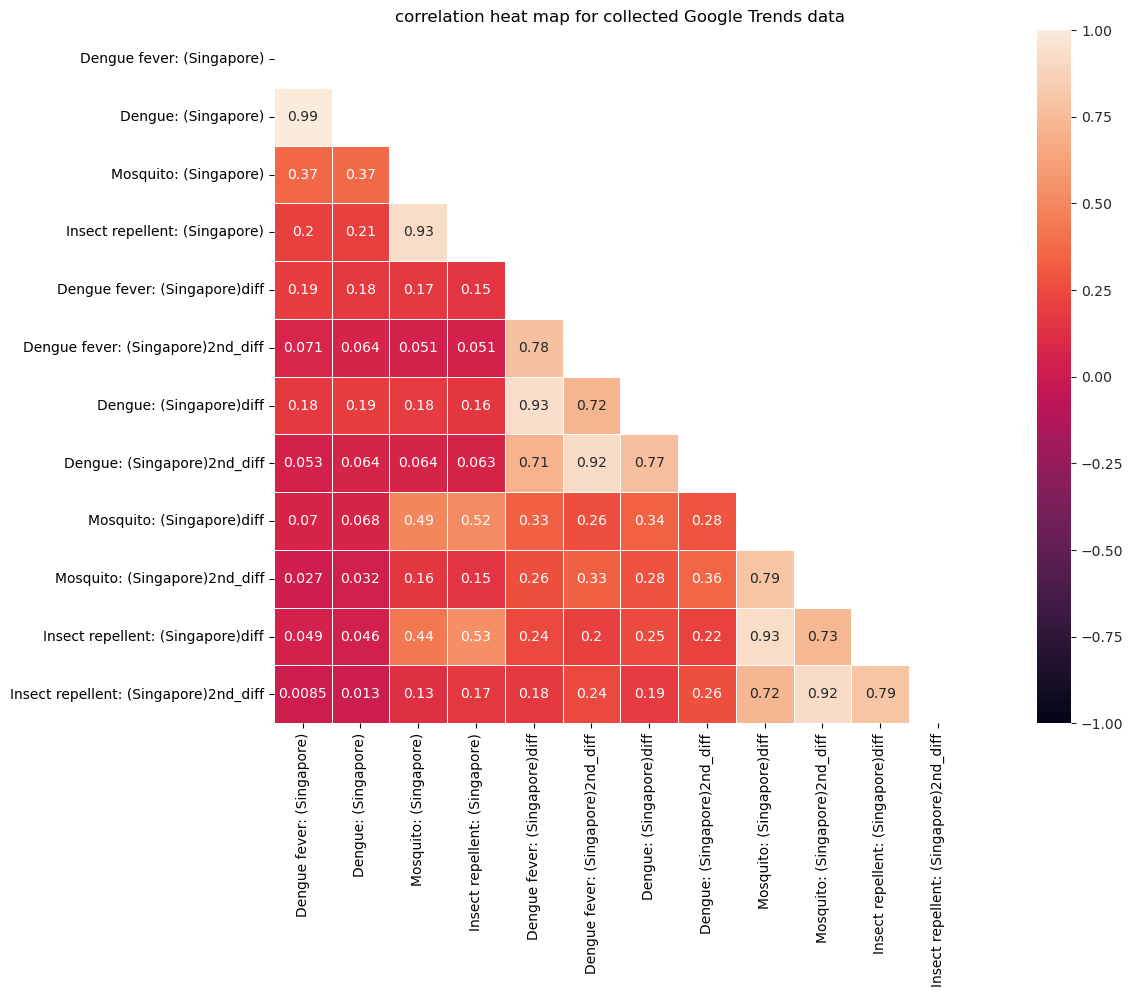

In [34]:
plt.figure(figsize = (18,9))
plt.title("correlation heat map for collected Google Trends data")
# Get correlation of variables.
corr = df.corr(numeric_only=True)
# Set up mask to be “True” in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Plot our correlation heatmap, while masking the upper triangle to be white.
with sns.axes_style("white"):
    sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5)

Correlation between the four search terms, except for `Dengue fever` and `Dengue` are low.  
This proves the previous points of the data are not exactly following each other or leading/ lagging one another.  
The correlation between 1st difference and 2nd difference are high.  
This is to be expected, as the 1st difference basically captures the trend/ changes in the original data.  
Similarly, 2nd diff captures the trend present in the 1st difference.  

In [35]:
name_list = ['Week', 'Dengue fever: (Singapore)', 'Dengue: (Singapore)', 'Mosquito: (Singapore)', 'Insect repellent: (Singapore)',
             'Dengue fever: (Singapore)diff', 'Dengue: (Singapore)diff', 'Mosquito: (Singapore)diff', 'Insect repellent: (Singapore)diff',
             'Dengue fever: (Singapore)2nd_diff', 'Dengue: (Singapore)2nd_diff', 'Mosquito: (Singapore)2nd_diff', 'Insect repellent: (Singapore)2nd_diff',]
rename_list = ['week', 'dengue_fever', 'dengue', 'mosquito', 'insect_repellent',
               'dengue_fever_diff', 'dengue_diff', 'mosquito_diff', 'insect_repellent_diff',
               'dengue_fever_2nd_diff', 'dengue_2nd_diff', 'mosquito_2nd_diff', 'insect_repellent_2nd_diff']
name_dict = {}
for i, name in enumerate(name_list):
    name_dict[name] = rename_list[i]

In [36]:
df_copy = df.rename(columns=name_dict)

In [37]:
df_copy.head()

,week,dengue_fever,dengue,mosquito,insect_repellent,dengue_fever_diff,dengue_fever_2nd_diff,dengue_diff,dengue_2nd_diff,mosquito_diff,mosquito_2nd_diff,insect_repellent_diff,insect_repellent_2nd_diff
0,2013-05-26,33,30,10,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-06-02,29,28,9,3,-4.0,NaN,-2.0,NaN,-1.0,NaN,1.0,NaN
2,2013-06-09,56,52,18,4,27.0,31.0,24.0,26.0,9.0,10.0,1.0,0.0
3,2013-06-16,42,39,14,2,-14.0,-41.0,-13.0,-37.0,-4.0,-13.0,-2.0,-3.0
4,2013-06-23,25,23,8,2,-17.0,-3.0,-16.0,-3.0,-6.0,-2.0,0.0,2.0


In [38]:
df_copy.to_csv('../data/cleaned_google_data.csv')

## Original Data

Unser this section, the acf and pacf of the four search reseults are plotted.  
ADF and KPSS are performed.

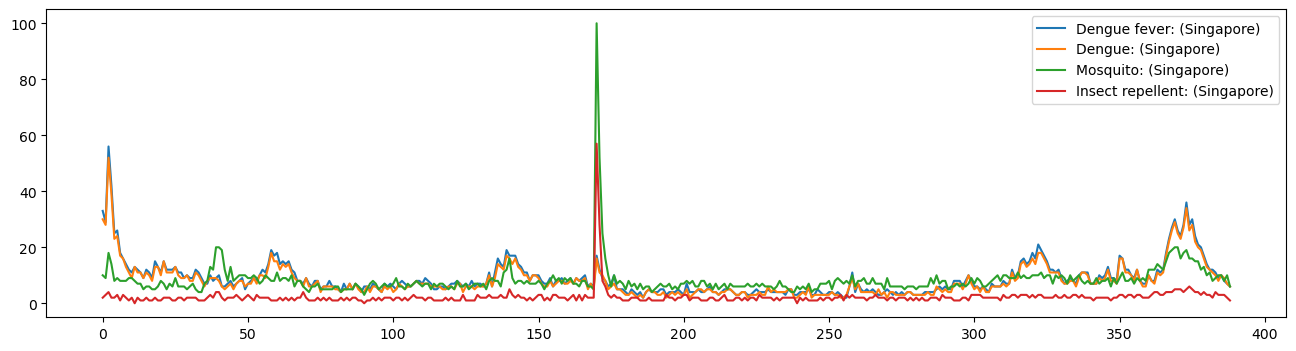

In [39]:
# Plot the original data
fig = plt.figure(figsize=(16,4))
plt.plot(df.index, df.iloc[:,1:5]);
plt.legend(['Dengue fever: (Singapore)', 'Dengue: (Singapore)', 'Mosquito: (Singapore)', 'Insect repellent: (Singapore)']);

In [40]:
def adf_test(series, col_title):
    stats, p, n_lag, n_data, crit_val, num = adfuller(series)
    # Format Output
    print('ADF Test for '+col_title+": ")
    print(f'ADF Statistic: {stats}')
    print(f'p-value: {p}')
    print(f'num lags: {n_lag}')
    print(f'num data pts: {n_data}')
    print('Critial Values:')
    for key, value in crit_val.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"" if p < 0.05 else "not "}stationary at significance level of 0.05.')
    print("")

In [41]:
for col_title in title_list:
    adf_test(df[col_title], col_title)

ADF Test for Dengue fever: (Singapore): 
ADF Statistic: -3.5782175391948243
p-value: 0.0061913793405563985
num lags: 12
num data pts: 376
Critial Values:
   1% : -3.4478619826418817
   5% : -2.869257669826291
   10% : -2.570881358363513
Result: The series is stationary at significance level of 0.05.

ADF Test for Dengue: (Singapore): 
ADF Statistic: -3.600521485494804
p-value: 0.005751065890620523
num lags: 13
num data pts: 375
Critial Values:
   1% : -3.447909006729481
   5% : -2.8692783343881483
   10% : -2.5708923751111112
Result: The series is stationary at significance level of 0.05.

ADF Test for Mosquito: (Singapore): 
ADF Statistic: -11.1489757253213
p-value: 2.9765282932002934e-20
num lags: 0
num data pts: 388
Critial Values:
   1% : -3.4473167281607155
   5% : -2.869018036958473
   10% : -2.5707536074503134
Result: The series is stationary at significance level of 0.05.

ADF Test for Insect repellent: (Singapore): 
ADF Statistic: -12.401591334620479
p-value: 4.548003515160289

For all four data, at significance level of 0.05, the ADF test result have sufficient evidence to reject H0.  
ADF H0 specifies that series is none stationary.  
By rejecting H0, we are saying that the series is likely stationary.  

In [42]:
def kpss_test(series, col_title, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print('KPSS Test for '+col_title+": ")
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary at significance level of 0.05.')
    print("")

In [43]:
warnings.filterwarnings('ignore')
for col_title in title_list:
    kpss_test(df[col_title], col_title)

KPSS Test for Dengue fever: (Singapore): 
KPSS Statistic: 0.4172520477321125
p-value: 0.06971894494305496
num lags: 11
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary at significance level of 0.05.

KPSS Test for Dengue: (Singapore): 
KPSS Statistic: 0.42383323285942065
p-value: 0.06688222721576698
num lags: 11
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary at significance level of 0.05.

KPSS Test for Mosquito: (Singapore): 
KPSS Statistic: 0.2285783962944024
p-value: 0.1
num lags: 8
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary at significance level of 0.05.

KPSS Test for Insect repellent: (Singapore): 
KPSS Statistic: 0.16763502385474324
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary at significance level of 0.05.



Similarily for KPSS all four series returned the same result.  
H0 for KPSS is that trend is stationary.  
Here, we do not reject H0 and conclude that trend is stationary, like ADF.  

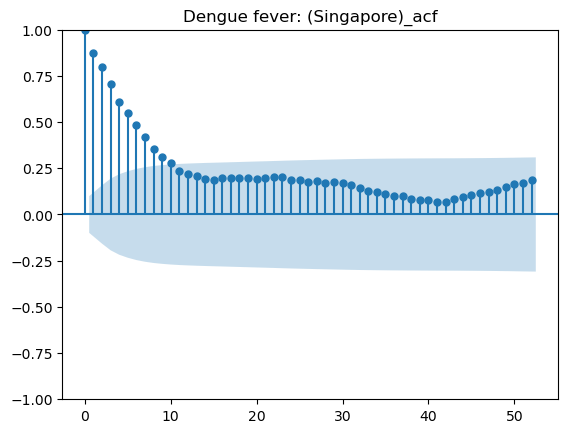

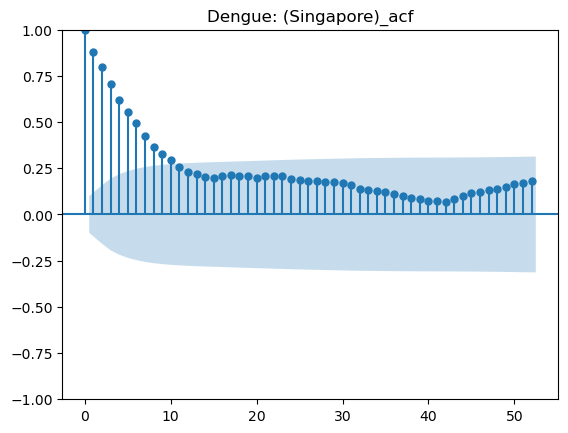

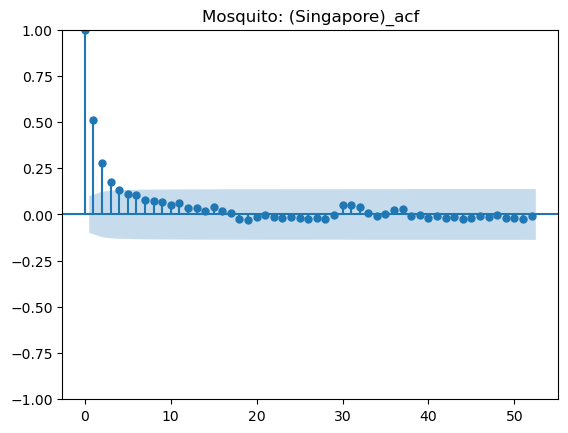

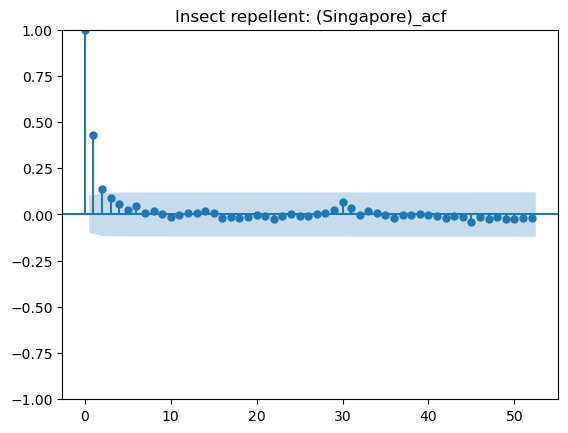

In [44]:
for col_title in title_list:
    # Generate autocorrelation plot on training data.
    plot_acf(df[col_title], lags = 52, title=col_title+'_acf');

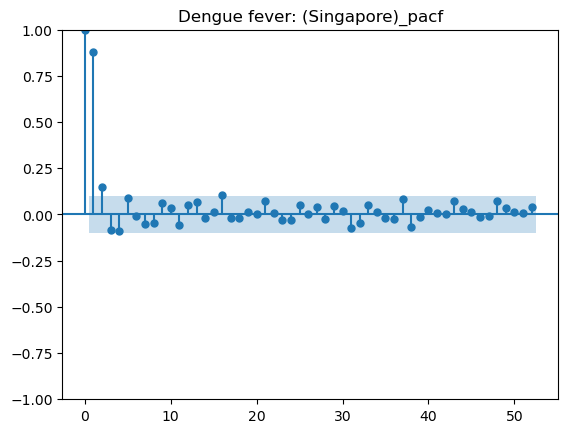

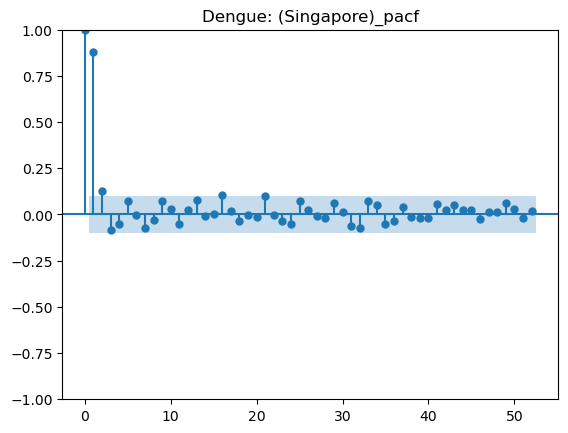

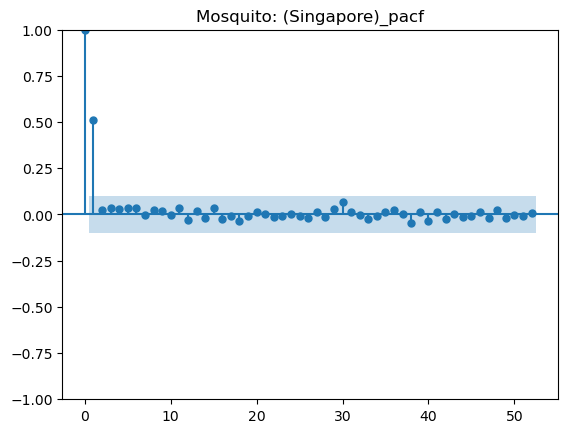

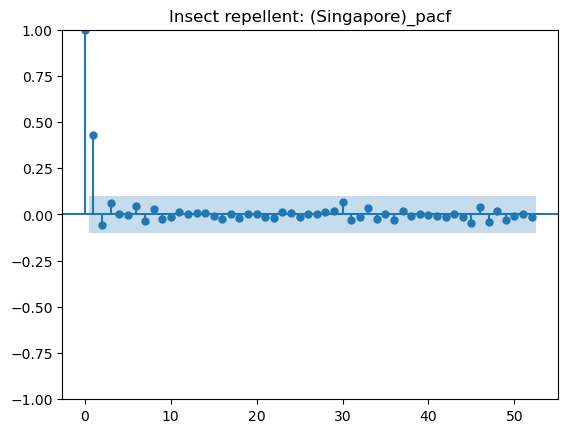

In [45]:
warnings.filterwarnings('ignore')
for col_title in title_list:
    # Generate autocorrelation plot on training data.
    plot_pacf(df[col_title], lags = 52, title=col_title+'_pacf');

## 1st Diff

The tests and graphs below are conducted on the 1st difference of the four series collected from Google Trend.

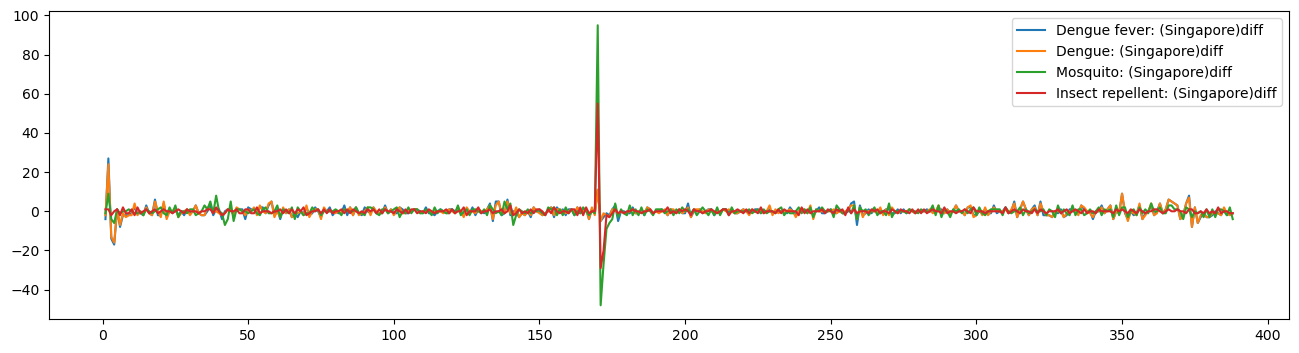

In [46]:
# Plot the data for 1st difference.  
fig = plt.figure(figsize=(16,4))
plt.plot(df.index[1:], df.iloc[1:,5]);
plt.plot(df.index[1:], df.iloc[1:,7]);
plt.plot(df.index[1:], df.iloc[1:,9]);
plt.plot(df.index[1:], df.iloc[1:,11]);
plt.legend(['Dengue fever: (Singapore)diff', 'Dengue: (Singapore)diff', 'Mosquito: (Singapore)diff', 'Insect repellent: (Singapore)diff']);

In [47]:
title_list_2 = ['Dengue fever: (Singapore)diff', 'Dengue: (Singapore)diff', 'Mosquito: (Singapore)diff', 'Insect repellent: (Singapore)diff']

In [48]:
for col_title in title_list_2:
    adf_test(df[col_title].dropna(), col_title)

ADF Test for Dengue fever: (Singapore)diff: 
ADF Statistic: -7.042471728178206
p-value: 5.798979549987971e-10
num lags: 12
num data pts: 375
Critial Values:
   1% : -3.447909006729481
   5% : -2.8692783343881483
   10% : -2.5708923751111112
Result: The series is stationary at significance level of 0.05.

ADF Test for Dengue: (Singapore)diff: 
ADF Statistic: -7.02175890355448
p-value: 6.515991370124067e-10
num lags: 12
num data pts: 375
Critial Values:
   1% : -3.447909006729481
   5% : -2.8692783343881483
   10% : -2.5708923751111112
Result: The series is stationary at significance level of 0.05.

ADF Test for Mosquito: (Singapore)diff: 
ADF Statistic: -9.597621067487534
p-value: 1.9590283119708165e-16
num lags: 9
num data pts: 378
Critial Values:
   1% : -3.4477686860685
   5% : -2.869216670067509
   10% : -2.570859500573892
Result: The series is stationary at significance level of 0.05.

ADF Test for Insect repellent: (Singapore)diff: 
ADF Statistic: -9.341869612430798
p-value: 8.752

In [49]:
warnings.filterwarnings('ignore')
for col_title in title_list_2:
    kpss_test(df[col_title][1:], col_title)

KPSS Test for Dengue fever: (Singapore)diff: 
KPSS Statistic: 0.11012789543899622
p-value: 0.1
num lags: 3
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary at significance level of 0.05.

KPSS Test for Dengue: (Singapore)diff: 
KPSS Statistic: 0.10970085264383869
p-value: 0.1
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary at significance level of 0.05.

KPSS Test for Mosquito: (Singapore)diff: 
KPSS Statistic: 0.06455540527653778
p-value: 0.1
num lags: 48
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary at significance level of 0.05.

KPSS Test for Insect repellent: (Singapore)diff: 
KPSS Statistic: 0.09233915131051612
p-value: 0.1
num lags: 69
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary at significance level of 0.05.



Conclusion is similar.  
The trend is stationary for 1st difference too. 

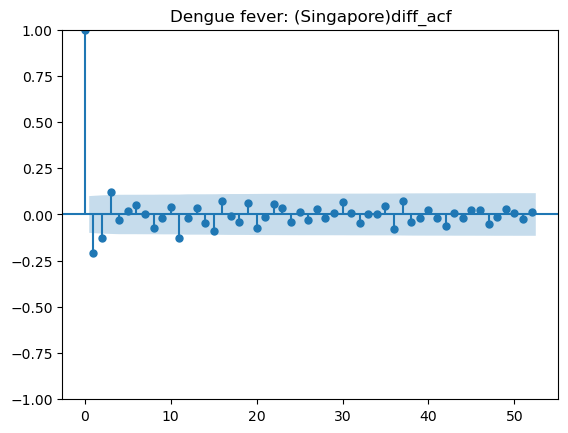

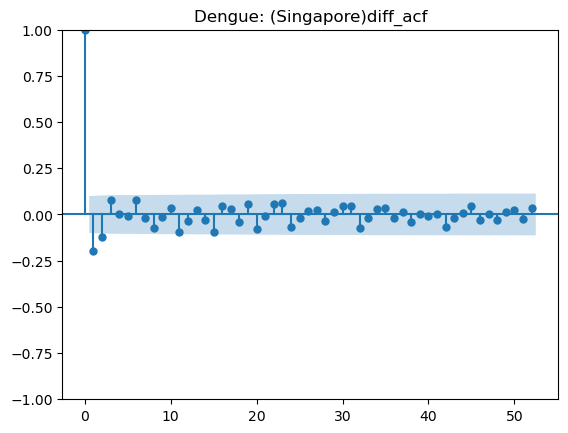

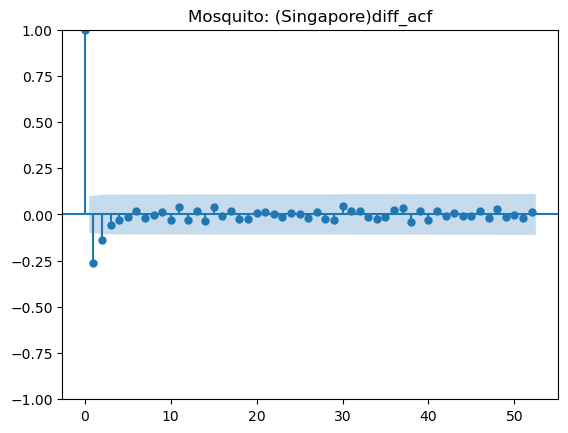

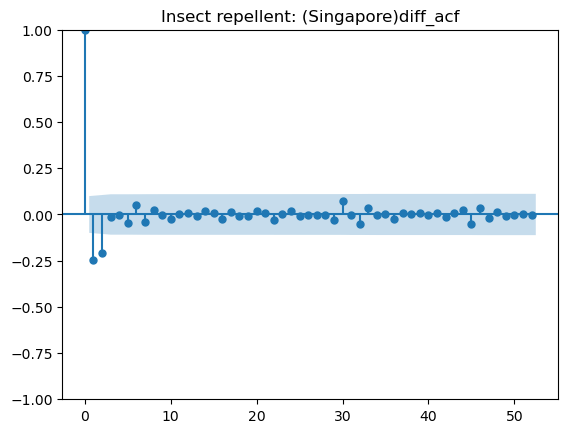

In [50]:
for col_title in title_list_2:
    # Generate autocorrelation plot on training data.
    plot_acf(df[col_title].dropna(), lags = 52, title=col_title+'_acf');

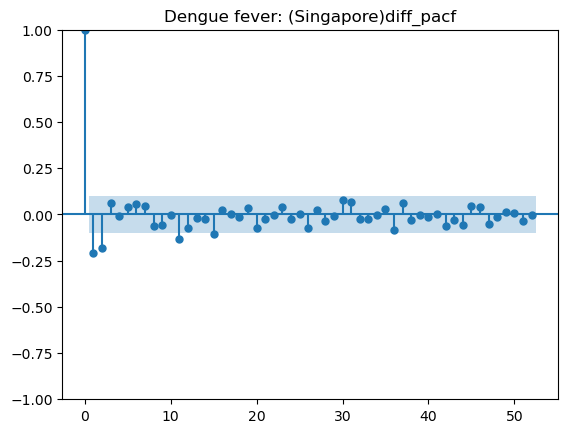

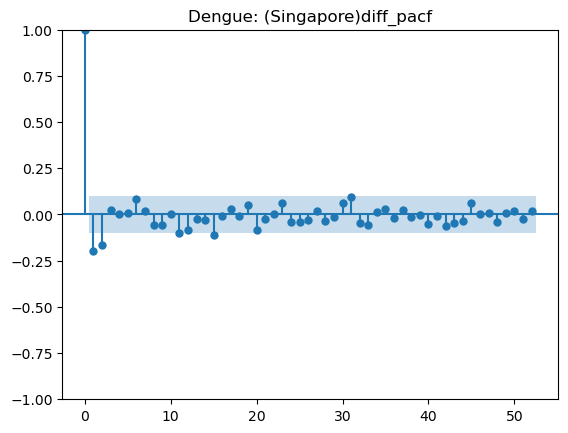

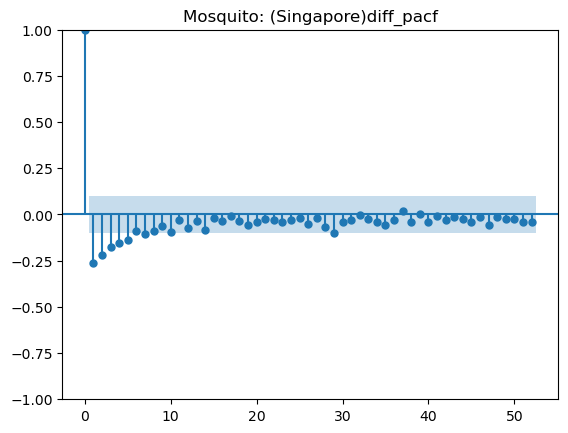

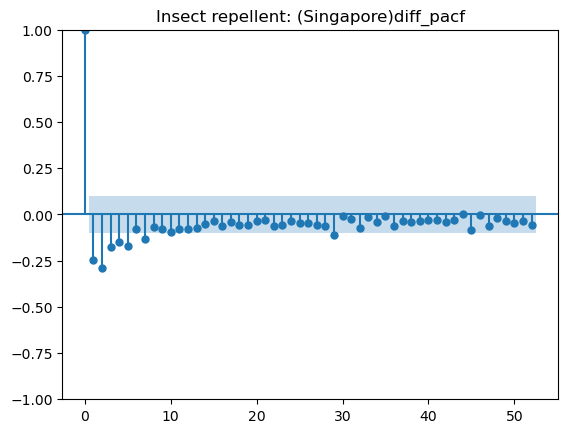

In [51]:
warnings.filterwarnings('ignore')
for col_title in title_list_2:
    # Generate autocorrelation plot on training data.
    plot_pacf(df[col_title].dropna(), lags = 52, title=col_title+'_pacf');

## 2nd Diff

The cells below shows the KPSS and ADF for 2nd differencing of the time series data.  
The respective plot for ACF and PACF are plotted.  

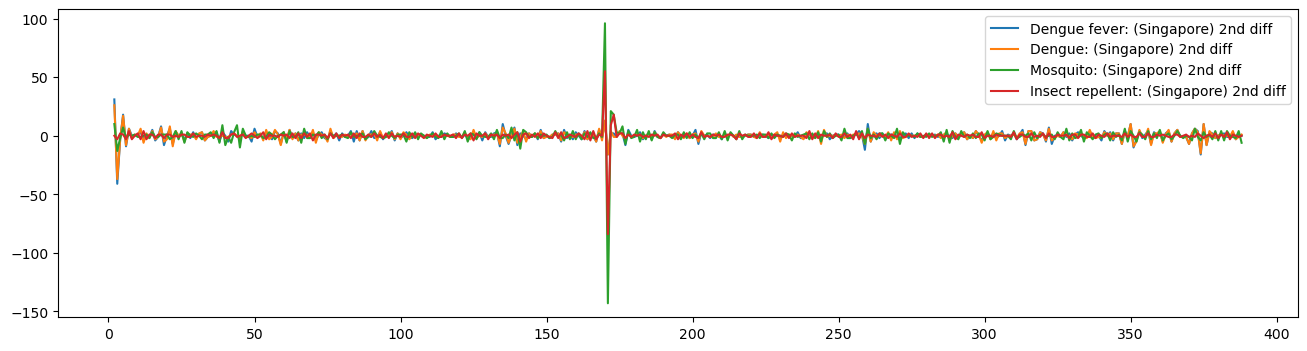

In [52]:
# Plot the data for 2nd difference.  
fig = plt.figure(figsize=(16,4))
plt.plot(df.index[1:], df.iloc[1:,6]);
plt.plot(df.index[1:], df.iloc[1:,8]);
plt.plot(df.index[1:], df.iloc[1:,10]);
plt.plot(df.index[1:], df.iloc[1:,12]);
plt.legend(['Dengue fever: (Singapore) 2nd diff', 'Dengue: (Singapore) 2nd diff', 'Mosquito: (Singapore) 2nd diff', 'Insect repellent: (Singapore) 2nd diff']);

In [53]:
title_list_3 = ['Dengue fever: (Singapore)2nd_diff', 'Dengue: (Singapore)2nd_diff', 'Mosquito: (Singapore)2nd_diff', 'Insect repellent: (Singapore)2nd_diff']

In [54]:
for col_title in title_list_3:
    adf_test(df[col_title].dropna(), col_title)

ADF Test for Dengue fever: (Singapore)2nd_diff: 
ADF Statistic: -9.003556308469703
p-value: 6.400952266986164e-15
num lags: 17
num data pts: 369
Critial Values:
   1% : -3.448196541708585
   5% : -2.869404683789669
   10% : -2.5709597356805545
Result: The series is stationary at significance level of 0.05.

ADF Test for Dengue: (Singapore)2nd_diff: 
ADF Statistic: -9.276217690567366
p-value: 1.2868844192159838e-15
num lags: 17
num data pts: 369
Critial Values:
   1% : -3.448196541708585
   5% : -2.869404683789669
   10% : -2.5709597356805545
Result: The series is stationary at significance level of 0.05.

ADF Test for Mosquito: (Singapore)2nd_diff: 
ADF Statistic: -9.78300151638793
p-value: 6.656166139093683e-17
num lags: 16
num data pts: 370
Critial Values:
   1% : -3.448147967010838
   5% : -2.8693833397824413
   10% : -2.5709483564645725
Result: The series is stationary at significance level of 0.05.

ADF Test for Insect repellent: (Singapore)2nd_diff: 
ADF Statistic: -9.38100889658

In [55]:
warnings.filterwarnings('ignore')
for col_title in title_list_2:
    kpss_test(df[col_title][1:], col_title)

KPSS Test for Dengue fever: (Singapore)diff: 
KPSS Statistic: 0.11012789543899622
p-value: 0.1
num lags: 3
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary at significance level of 0.05.

KPSS Test for Dengue: (Singapore)diff: 
KPSS Statistic: 0.10970085264383869
p-value: 0.1
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary at significance level of 0.05.

KPSS Test for Mosquito: (Singapore)diff: 
KPSS Statistic: 0.06455540527653778
p-value: 0.1
num lags: 48
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary at significance level of 0.05.

KPSS Test for Insect repellent: (Singapore)diff: 
KPSS Statistic: 0.09233915131051612
p-value: 0.1
num lags: 69
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary at significance level of 0.05.



Once again, the same conclusion of stationary trend can be made.

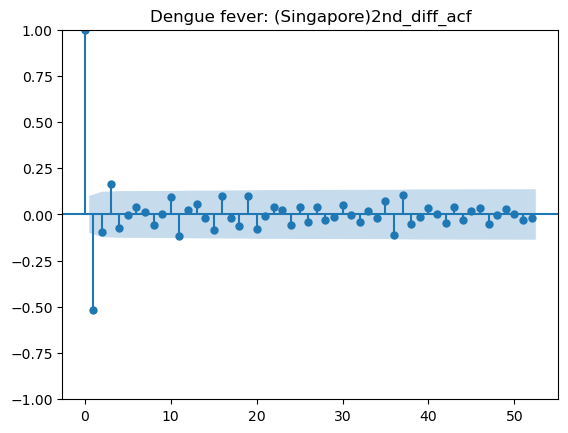

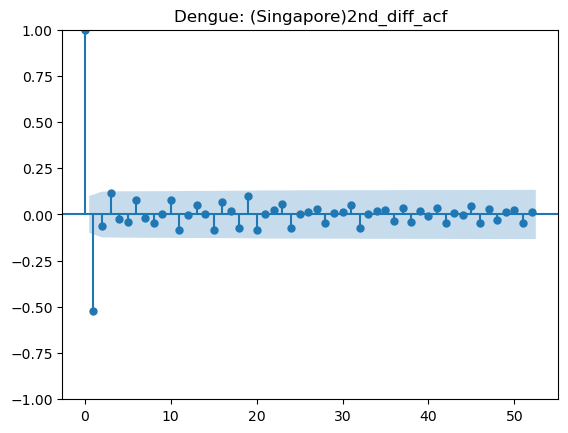

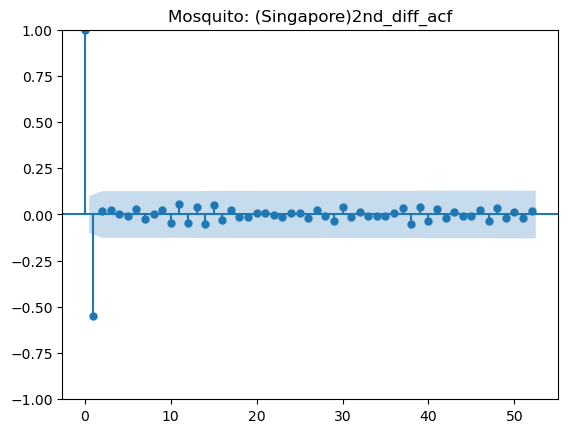

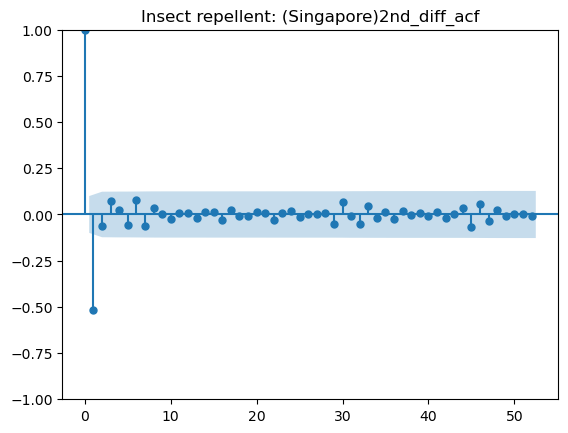

In [56]:
for col_title in title_list_3:
    # Generate autocorrelation plot on training data.
    plot_acf(df[col_title].dropna(), lags = 52, title=col_title+'_acf');

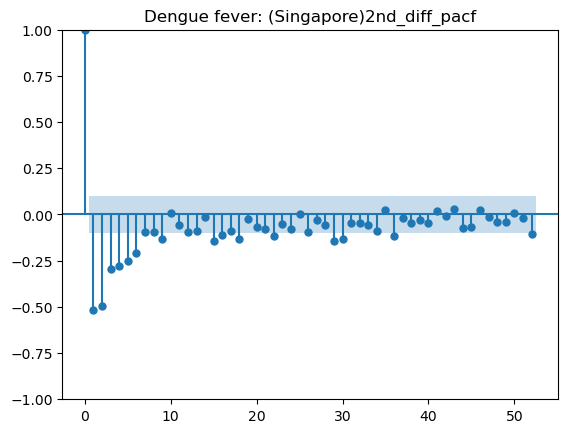

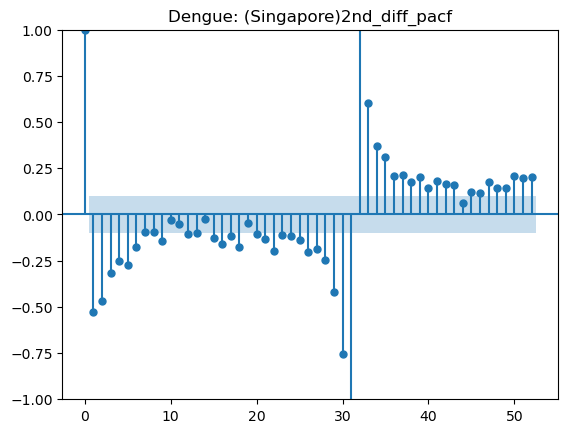

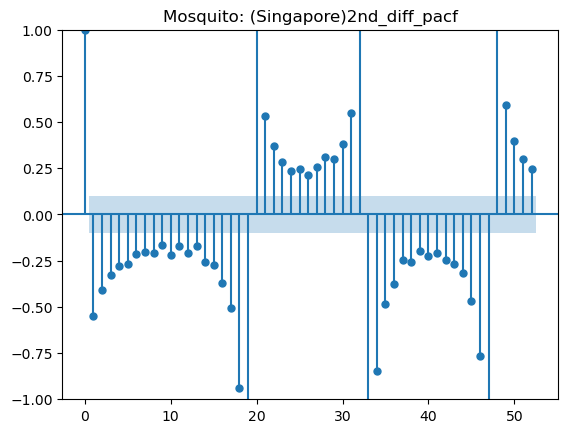

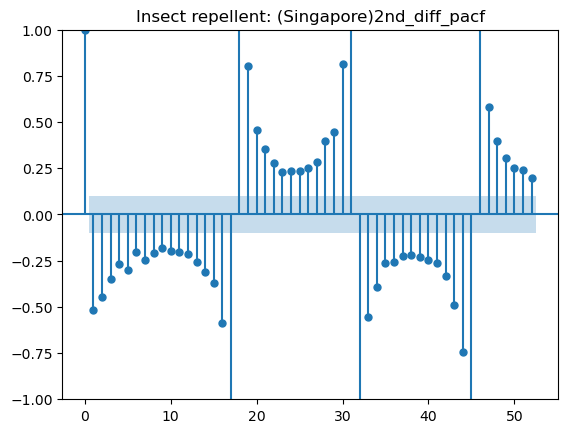

In [57]:
warnings.filterwarnings('ignore')
for col_title in title_list_3:
    # Generate autocorrelation plot on training data.
    plot_pacf(df[col_title].dropna(), lags = 52, title=col_title+'_pacf');

The Google Trend data are all stationary.  
This means that AR and MA models should be sufficient to predict them.  
However, upon trying, the ARIMA model and SARIMA models did not perform well.  
On the other hand, LSTM models preformed much better.  

As this notebook is for EDA only, the models will not be presented here.